<h1 style="text-align=center">NNDL - ETE3</h1>

Name: Kushal Sourav B<br />
Regno: 2347125


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import seaborn as sns

data = pd.read_csv('./weather_data.csv', parse_dates=['date'])
data.set_index('date', inplace=True)



In [11]:
print(data.head())

print(data.info())
print(data.describe())


print(data.isnull().sum())

            temperature
date                   
2014-01-01    10.248357
2014-01-02     9.950428
2014-01-03    10.362958
2014-01-04    10.820167
2014-01-05     9.961091
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB
None
       temperature
count  2557.000000
mean     10.017472
std       0.923047
min       3.337291
25%       9.335195
50%      10.031778
75%      10.681384
max      15.587945
temperature    0
dtype: int64


* Load the dataset containing temperature and date columns.
* Use parse_dates to parse the date column as datetime.
* Set the date column as the index for easier time-series handling.

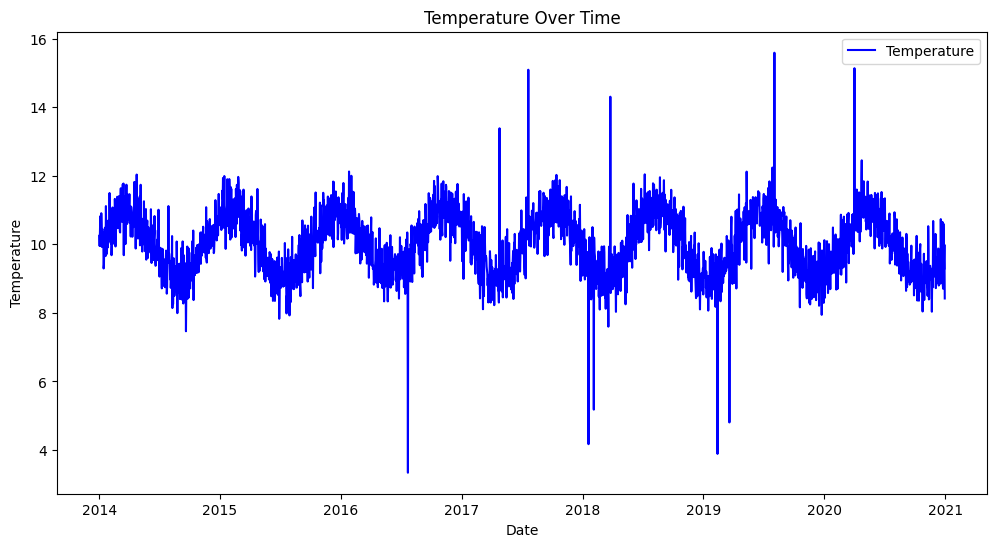

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature'], label='Temperature', color='blue')
plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Purpose:

To observe the temperature trends over time and identify seasonal patterns, spikes, or drops..

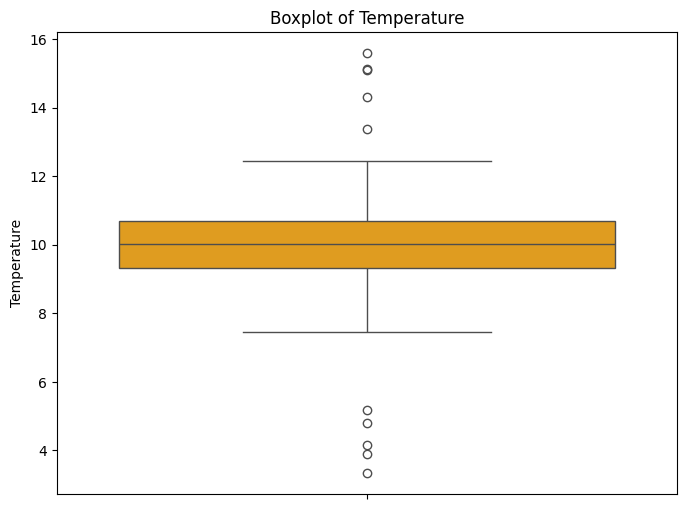

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=data['temperature'], color='orange')
plt.title("Boxplot of Temperature")
plt.ylabel("Temperature")
plt.show()


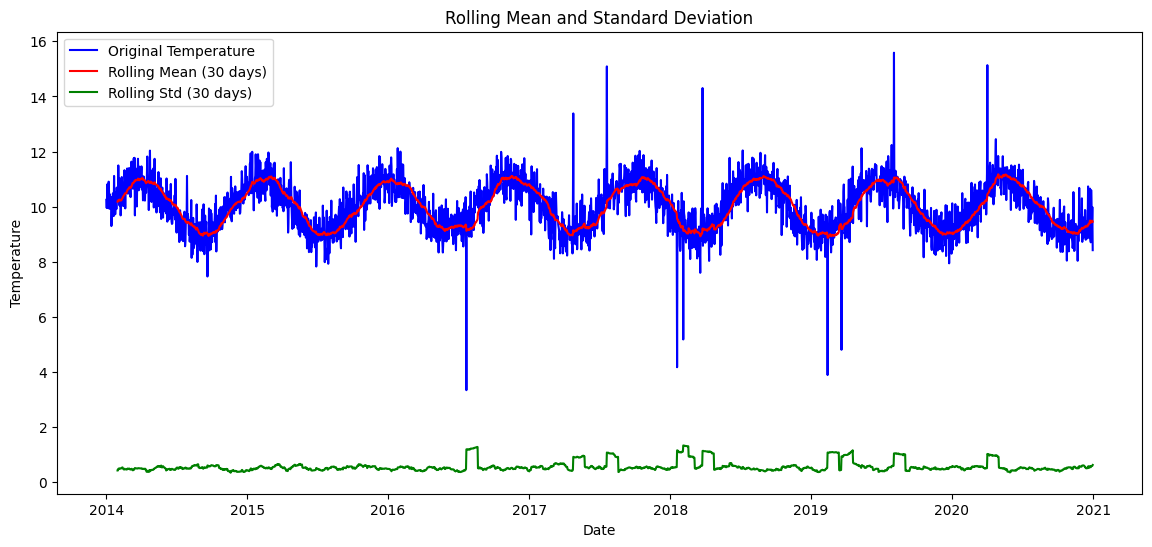

In [19]:
rolling_mean = data['temperature'].rolling(window=30).mean()
rolling_std = data['temperature'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['temperature'], label='Original Temperature', color='blue')
plt.plot(data.index, rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(data.index, rolling_std, label='Rolling Std (30 days)', color='green')
plt.title("Rolling Mean and Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [3]:

scaler = MinMaxScaler()
data['temperature'] = scaler.fit_transform(data[['temperature']])


train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

time_steps = 30  
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data.iloc[i: i + time_steps].values
        sequences.append(seq)
    return np.array(sequences)

train_sequences = create_sequences(train_data, time_steps)
test_sequences = create_sequences(test_data, time_steps)


* Normalize the temperature column to the range [0, 1] using MinMaxScaler.
* Split the dataset into training (80%) and testing (20%) sets without shuffling since it's time-series data.
* Convert data into sequences of time_steps length for LSTM input.

In [4]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(time_steps),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

* The encoder reduces the input dimension using two LSTM layers.
* The decoder reconstructs the input using a RepeatVector and LSTM layers.
* TimeDistributed(Dense(1)) outputs the reconstructed sequences.

Encoder 
* The first LSTM layer with 64 units processes sequences while returning sequences for further processing.
* The second LSTM layer with 32 units reduces the sequence into a latent representation, which is a fixed-length vector representing the input sequence.

Decoder
* RepeatVector(time_steps): Expands the latent vector back into a sequence with the same length as the input.
* Two LSTM layers with 32 and 64 units reconstruct the temporal structure.
* TimeDistributed(Dense(1)): Outputs the reconstructed sequences for each time step.

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 0.1374 - val_loss: 0.0191
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0171 - val_loss: 0.0067
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.

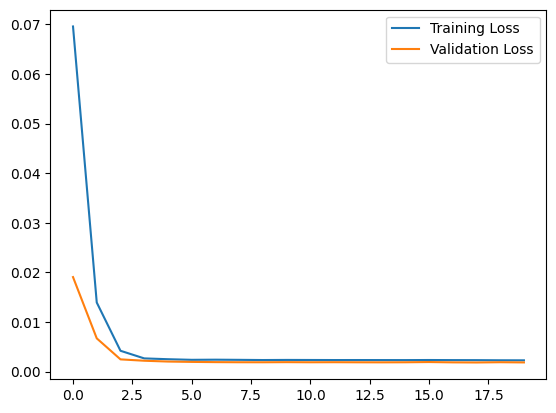

In [5]:

history = model.fit(train_sequences, train_sequences, epochs=20, batch_size=32, 
                    validation_data=(test_sequences, test_sequences), verbose=1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


* Train the autoencoder using training sequences as both input and output.
* Visualize the training and validation loss to monitor model performance.

In [16]:

train_predictions = model.predict(train_sequences)
test_predictions = model.predict(test_sequences)

train_error = np.mean(np.power(train_sequences - train_predictions, 2), axis=(1, 2))
test_error = np.mean(np.power(test_sequences - test_predictions, 2), axis=(1, 2))

print("Training Error Stats:", pd.Series(train_error).describe())
print("Testing Error Stats:", pd.Series(test_error).describe())


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training Error Stats: count    2015.000000
mean        0.002261
std         0.001895
min         0.000589
25%         0.001351
50%         0.001675
75%         0.002026
max         0.011240
dtype: float64
Testing Error Stats: count    482.000000
mean       0.001856
std        0.001042
min        0.000846
25%        0.001416
50%        0.001600
75%        0.001873
max        0.006320
dtype: float64


Understanding the distribution of reconstruction errors helps set a threshold for anomaly detection.

In [24]:
threshold = np.percentile(train_error, 50)

print("Reconstruction Error Threshold:", threshold)

Reconstruction Error Threshold: 0.0016746018962416754


The threshold is chosen to ensure that only the 50% of reconstruction errors are flagged as anomalies.

In [25]:
# Identify anomalies
test_anomalies = test_error > threshold
anomaly_dates = test_data.index[time_steps:][test_anomalies]

print(f"Number of Anomalies Detected: {len(anomaly_dates)}")
print("Anomalous Dates:", anomaly_dates)

Number of Anomalies Detected: 202
Anomalous Dates: DatetimeIndex(['2019-09-16', '2019-09-17', '2019-09-18', '2019-09-19',
               '2019-09-20', '2019-09-21', '2019-09-22', '2019-09-23',
               '2019-09-27', '2019-09-28',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=202, freq=None)


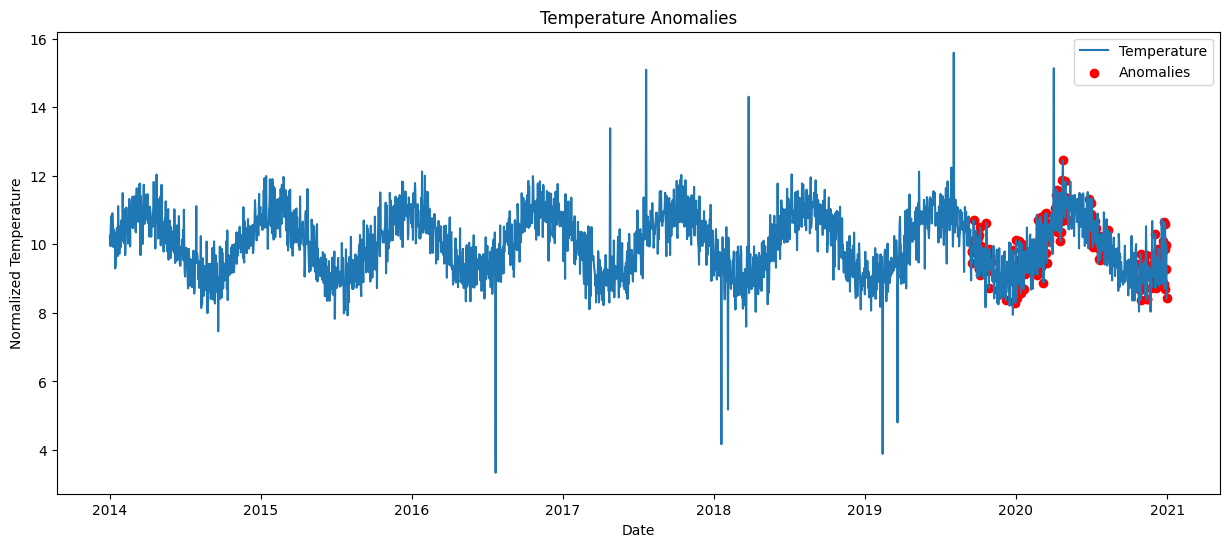

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['temperature'], label='Temperature')
plt.scatter(anomaly_dates, data.loc[anomaly_dates, 'temperature'], color='red', label='Anomalies')
plt.legend()
plt.title("Temperature Anomalies")
plt.xlabel("Date")
plt.ylabel("Normalized Temperature")
plt.show()


### Anomalies Detected
Total Anomalies: 202 days out of 2,557 days (~7.9% of the data).
#### Anomaly Periods:
* Many anomalies were concentrated toward the latter part of the dataset, particularly in 2019-2020, suggesting unusual patterns in the temperature during these years.
* Some periods, such as September 2019 and December 2020, saw clusters of anomalies, potentially indicating rapid changes or unusual weather events.